# 💤 Drowsiness Detection — Optimized
Refactored and optimized notebook with fine-tuning, regularization,
callbacks, improved augmentation, and a live webcam demo.


## 📦 Imports and Environment Setup

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

tf.get_logger().setLevel('ERROR')


## 📂 Dataset Paths (update if needed)

In [5]:
# Update these paths if your dataset location differs
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
BASE_DIR =  os.path.join(parent_dir, "data")
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

CLASS_NAMES = ['closed', 'no_yawn', 'open', 'yawn']

print("Training directory ", TRAIN_DIR)
print("Validation/test directory ",TEST_DIR)

Training directory  H:\GitHub\ML_DriverDrowsinessDetection\data\train
Validation/test directory  H:\GitHub\ML_DriverDrowsinessDetection\data\test


## 🔄 Data Generators & Class Weights

In [6]:
def create_generators(train_dir, test_dir, img_size=(224,224), batch_size=32, val_split=0.2):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.2,
        zoom_range=0.3,
        brightness_range=[0.5,1.5],
        channel_shift_range=25.0,     # NEW: color jitter
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=val_split
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', subset='training', shuffle=True
    )

    val_gen = train_datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', subset='validation', shuffle=True
    )

    test_gen = test_datagen.flow_from_directory(
        test_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', shuffle=False
    )

    # Compute class weights to handle imbalance
    from sklearn.utils.class_weight import compute_class_weight
    labels = train_gen.classes
    classes = np.unique(labels)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
    class_weights_dict = {i: w for i, w in enumerate(class_weights)}

    return train_gen, val_gen, test_gen, class_weights_dict

# create generators (modify batch_size if needed)
train_gen, val_gen, test_gen, class_weights = create_generators(TRAIN_DIR, TEST_DIR, batch_size=32)
print('Class weights:', class_weights)


Found 1975 images belonging to 4 classes.
Found 492 images belonging to 4 classes.
Found 433 images belonging to 4 classes.
Class weights: {0: np.float64(0.9994939271255061), 1: np.float64(0.9994939271255061), 2: np.float64(1.0015212981744421), 3: np.float64(0.9994939271255061)}


## 🧠 Build & Compile Model (with L2 Regularization + Fine-tuning)

In [7]:
def build_model(num_classes=4, input_shape=(224,224,3), l2_reg=0.001, fine_tune_at=-10):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x) 
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg))(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    # Freeze most layers, unfreeze only last N
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in base_model.layers[fine_tune_at:]:
        layer.trainable = True

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Build model
model = build_model(num_classes=len(CLASS_NAMES), fine_tune_at=-10)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,268,228 (8.65 MB)

 Trainable params: 740,164 (2.82 MB)

 Non-trainable params: 1,528,064 (5.83 MB)

## 🚀 Train (with callbacks + checkpointing)

In [8]:
# Callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',   # look at validation loss
    factor=0.3,           # reduce LR to 30% of current value
    patience=3,           # wait 3 epochs before reducing
    min_lr=1e-6,          # don’t go below this value
    verbose=1             # print when LR is reduced
)
early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

EPOCHS = 30

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stop, checkpoint],
    class_weight=class_weights,
    verbose=1
)


C:\Users\ranji\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5970 - loss: 1.2336
Epoch 1: val_accuracy improved from None to 0.71951, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.6947 - loss: 0.8724 - val_accuracy: 0.7195 - val_loss: 0.5364 - learning_rate: 1.0000e-04
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7950 - loss: 0.5595
Epoch 2: val_accuracy did not improve from 0.71951
62/62 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.7919 - loss: 0.5793 - val_accuracy: 0.7093 - val_loss: 0.6941 - learning_rate: 1.0000e-04
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8399 - loss: 0.4078
Epoch 3: val_accuracy improved from 0.71951 to 0.73171, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.8284 - loss: 0.4467 - val_accuracy: 0.7317 - val_loss: 0.6851 - learning_rate: 1.0000e-04
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8199 - loss: 0.5083
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.

Epoch 4: val_accuracy did not improve from 0.73171
62/62 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8238 - loss: 0.4821 - val_accuracy: 0.7195 - val_loss: 1.0603 - learning_rate: 1.0000e-04
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8344 - loss: 0.4167
Epoch 5: val_accuracy improved from 0.73171 to 0.73374, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8375 - loss: 0.4018 - val_accuracy: 0.7337 - val_loss: 0.8754 - learning_rate: 3.0000e-05
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8495 - loss: 0.4079
Epoch 6: val_accuracy did not improve from 0.73374
62/62 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8380 - loss: 0.4327 - val_accuracy: 0.7256 - val_loss: 0.7552 - learning_rate: 3.0000e-05
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8515 - loss: 0.3897
Epoch 7: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.

Epoch 7: val_accuracy improved from 0.73374 to 0.73984, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.8415 - loss: 0.4233 - val_accuracy: 0.7398 - val_loss: 0.7704 - learning_rate: 3.0000e-05
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8394 - loss: 0.4101
Epoch 8: val_accuracy improved from 0.73984 to 0.75000, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.8506 - loss: 0.3866 - val_accuracy: 0.7500 - val_loss: 0.6975 - learning_rate: 9.0000e-06
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8636 - loss: 0.3384
Epoch 9: val_accuracy did not improve from 0.75000
62/62 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.8618 - loss: 0.3522 - val_accuracy: 0.7236 - val_loss: 0.6651 - learning_rate: 9.0000e-06
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8472 - loss: 0.4022
Epoch 10: ReduceLROnPlateau reducing learning rate to 2.6999998226528985e-06.

Epoch 10: val_accuracy did not improve from 0.75000
62/62 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.8476 - loss: 0.4025 - val_accuracy: 0.7439 - val_loss: 0.7387 - learning_rate: 9.0000e-06
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8676 - loss: 0.3599
Epoch 11: val_accuracy did not improve from 0.75000
62/62 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.8648 - loss: 0.3659 - val_acc

62/62 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8673 - loss: 0.3284 - val_accuracy: 0.7846 - val_loss: 0.6108 - learning_rate: 1.0000e-06
Epoch 15/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8374 - loss: 0.4290
Epoch 15: val_accuracy did not improve from 0.78455
62/62 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.8496 - loss: 0.3974 - val_accuracy: 0.7500 - val_loss: 0.6552 - learning_rate: 1.0000e-06
Epoch 16/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8714 - loss: 0.3315
Epoch 16: val_accuracy did not improve from 0.78455
62/62 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.8678 - loss: 0.3299 - val_accuracy: 0.7581 - val_loss: 0.5800 - learning_rate: 1.0000e-06
Epoch 17/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.8477 - loss: 0.3982 
Epoch 17: val_accuracy did not improve from 0.78455
62/62 ━━━━━━━━━━━━━━━━━━━━ 1616s 26s/step - accuracy: 0.8572 - loss: 0.3698 - val_accuracy: 0.7500 - val_loss: 0.5494 - learning_rate: 1.0000e-06
Epoch 18/30


## 📊 Training Curves

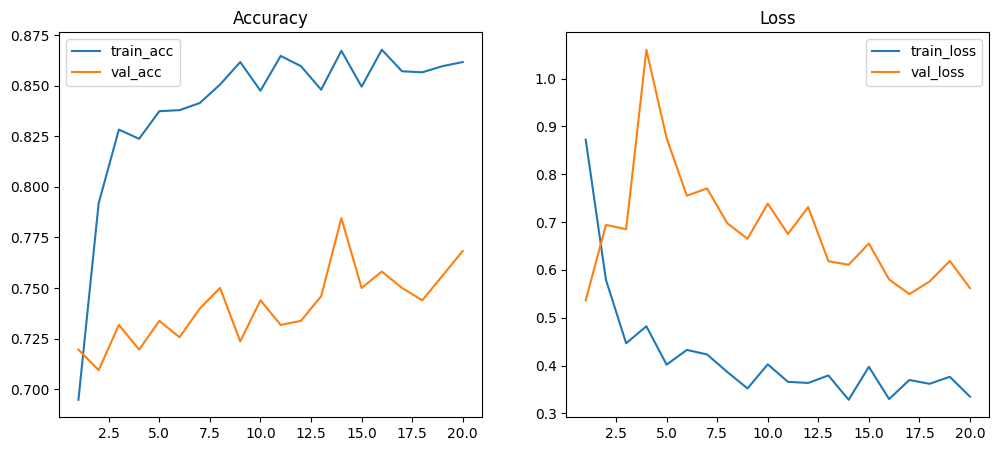

In [9]:
def plot_training(history):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='train_acc')
    plt.plot(epochs, val_acc, label='val_acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_training(history)


## ✅ Load Best Model & Evaluate on Test Set

In [11]:
# Load best saved model if available
if os.path.exists('best_model.h5'):
    best = load_model('best_model.h5')
else:
    best = model

test_loss, test_acc = best.evaluate(test_gen, verbose=1)
print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')


C:\Users\ranji\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8453 - loss: 0.3620
Test accuracy: 0.8453, Test loss: 0.3620


## 🧾 Confusion Matrix & Classification Report

14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 962ms/step
              precision    recall  f1-score   support

      Closed       1.00      0.97      0.99       109
        Open       0.97      1.00      0.99       109
     no_yawn       0.87      0.49      0.62       109
        yawn       0.64      0.92      0.75       106

    accuracy                           0.85       433
   macro avg       0.87      0.85      0.84       433
weighted avg       0.87      0.85      0.84       433



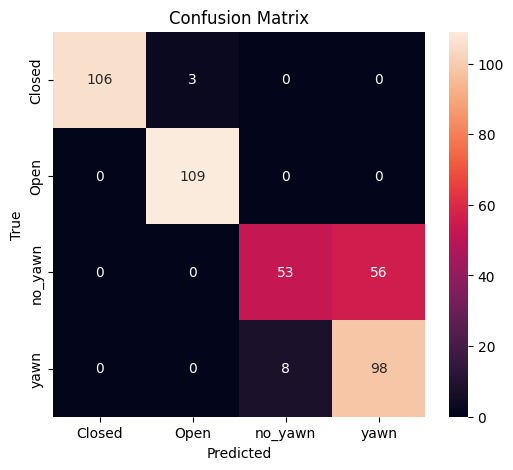

In [13]:

# Predict on test set
y_pred_probs = best.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(test_gen.class_indices.keys()),
            yticklabels=list(test_gen.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## 🎥 Live Webcam Demo (frame-by-frame + drowsiness scoring)

In [16]:
def live_webcam_prediction(model, class_names, img_size=(224,224), consecutive_frames_threshold=15):
    """Run live webcam feed and overlay predictions. If 'closed' or 'yawn' persists for
    `consecutive_frames_threshold` frames, an alert condition will be shown on screen."""
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print('Error: Could not open webcam.')
        return

    counter = 0
    last_alert = False

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = cv2.resize(rgb, img_size)
        img = img.astype('float32') / 255.0
        inp = np.expand_dims(img, axis=0)

        preds = model.predict(inp, verbose=0)[0]
        idx = np.argmax(preds)
        label = class_names[idx]
        conf = preds[idx]

        # Increment counter for drowsiness conditions
        if label in ['closed', 'yawn'] and conf > 0.65:
            counter += 1
        else:
            counter = max(0, counter - 1)

        # Trigger alert if threshold crossed
        alert = counter >= consecutive_frames_threshold

        # Overlay UI
        text = f"{label} ({conf:.2f})"
        cv2.putText(frame, text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2)
        cv2.putText(frame, f'Frames: {counter}', (20,80), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,0), 2)

        if alert:
            cv2.putText(frame, 'DROWSINESS ALERT!', (20,130), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,255), 3)
            # Optional: play a sound or perform other actions here
            last_alert = True
        else:
            if last_alert:
                # briefly show recovered status
                cv2.putText(frame, 'RECOVERED', (20,130), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2)
                last_alert = False

        cv2.imshow('Drowsiness Detection', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# To run the demo locally, uncomment below:
live_webcam_prediction(best, CLASS_NAMES)
